# 인물모드 프로젝트
- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라해보기
- 인물모드 문제점 찾기
셸로우 포커스를 만들어 인물과 배경을 분리

In [73]:
import cv2
import numpy as np
import os
import tarfile
import urllib
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib.image import imread

## 1. 인물모드 직접 해보기
### 사람
사람사진으로 흐린배경과 원본사진 합성

In [74]:
img_path = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_8/human_segmentation/images/image_4.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)

print (img_orig.shape)

(2000, 2000, 3)


In [75]:
#DeepLab 모델
##preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다.
##먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [76]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_8/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_8/human_segmentation/models
model loaded successfully!


In [77]:
#구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습
#라벨종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [81]:
img_dir=os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_8/human_segmentation/images'
def person_blur(file):
    img_path=os.path.join(img_dir,file)
    img_orig = cv2.imread(img_path)
    
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    #배경흐리게
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

#bitwise_not 함수를 이용하면 이미지가 반전됩니다. 
#배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 
#이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

    #배경 영상과 사람 영상을 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    

(2000, 2000, 3) (513, 513, 3) 16


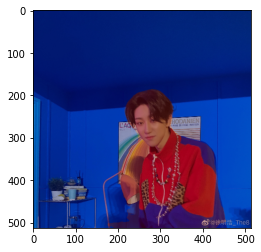

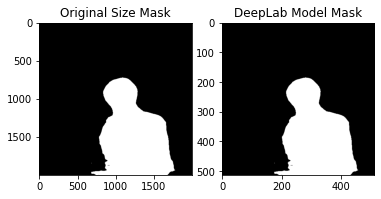

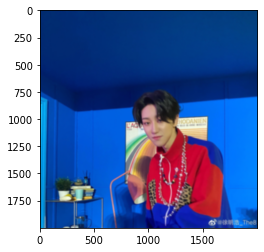

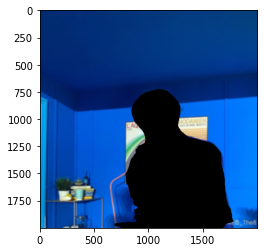

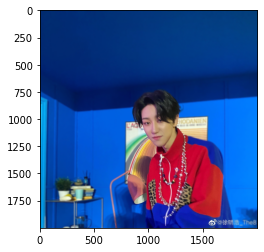

In [82]:
person_blur('image_4.jpg')

(2013, 1366, 3) (513, 348, 3) 15


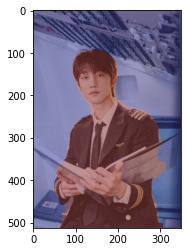

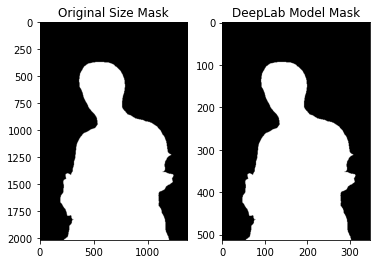

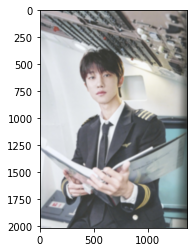

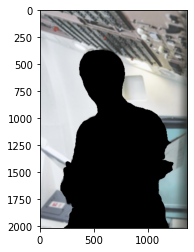

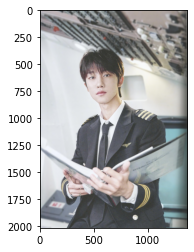

In [83]:
person_blur('image_5.jpg')

(1024, 768, 3) (513, 384, 3) 15


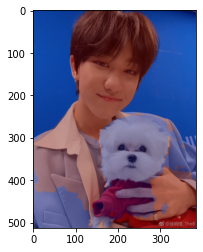

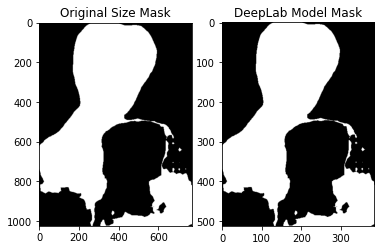

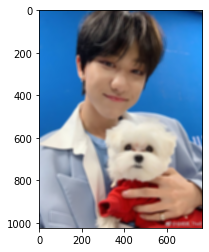

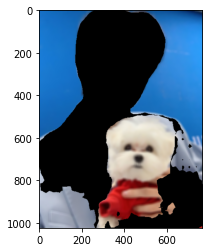

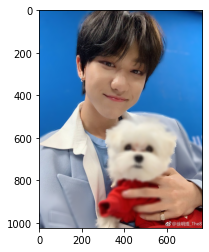

In [84]:
person_blur('image_6.jpg')

### 고양이
고양이사진으로 흐린배경과 원본사진 합성

In [89]:
img_dir=os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_8/human_segmentation/images'
def cat_blur(file):
    img_path=os.path.join(img_dir,file)
    img_orig = cv2.imread(img_path)
    
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    #배경흐리게
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

#bitwise_not 함수를 이용하면 이미지가 반전됩니다. 
#배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 
#이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

    #배경 영상과 사람 영상을 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    

(1115, 1125, 3) (508, 513, 3) 8


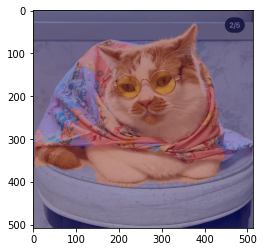

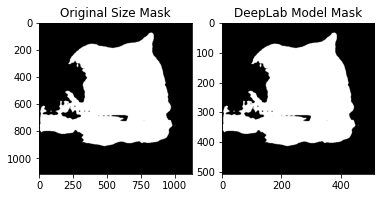

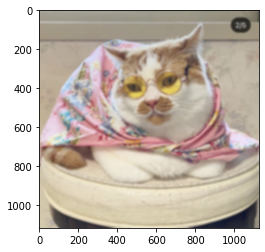

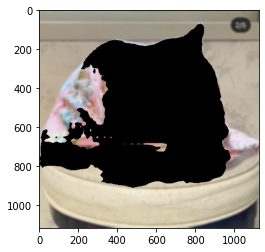

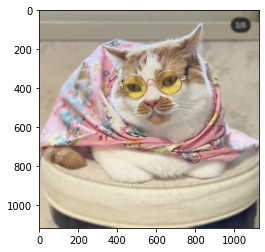

In [90]:
cat_blur('cat_1.jpg')

(1128, 1125, 3) (513, 511, 3) 9


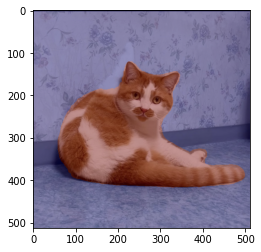

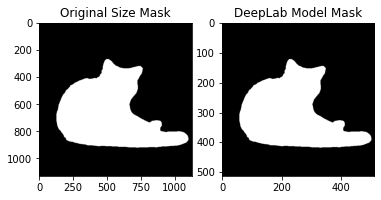

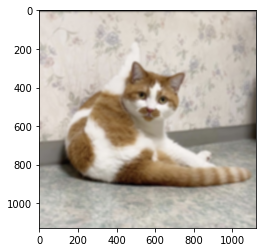

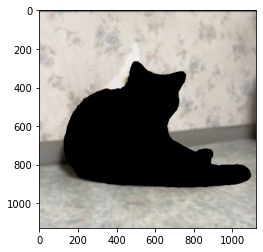

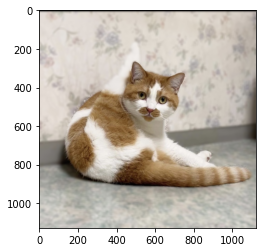

In [91]:
cat_blur('cat_3.jpg')

(1118, 1125, 3) (509, 513, 3) 18


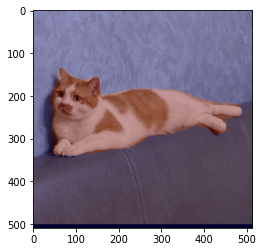

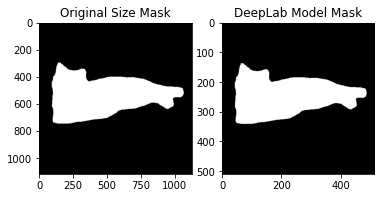

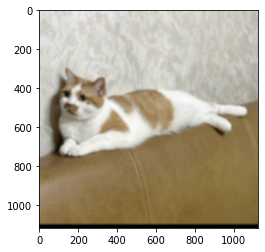

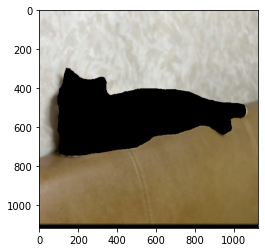

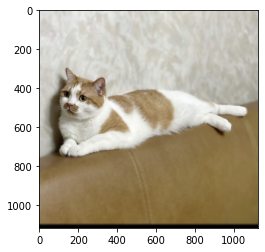

In [93]:
cat_blur('cat_4.jpg')

## 크로마키 배경 합성
크로마 키(Chroma key) 합성이란 녹색 또는 파란색 배경에서 찰영한 영상에 다른 배경 영상을 합성하는 기술

### 펭수 고향으로 보내주기
원본에 있는 펭수를 남극의 배경이랑 합성하기

In [97]:
img_dir=os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_8/human_segmentation/images'

def chromakey(file,background_file):
    img_path=os.path.join(img_dir,file)
    background_path=os.path.join(img_dir,background_file)
    img_orig = cv2.imread(img_path)
    img_background=cv2.imread(background_path)
    
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    #배경흐리게
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    #흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

#bitwise_not 함수를 이용하면 이미지가 반전됩니다. 
#배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 
#이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

    #배경 영상과 사람 영상을 합치기
    
    img_resized = cv2.resize(img_orig, (img_background.shape[1], img_background.shape[0]))
    img_mask_resized = cv2.resize(img_mask_color, (img_background.shape[1], img_background.shape[0]))

    img_background_concat = np.where(img_mask_resized == 255, img_resized, img_background)

    plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    

(431, 801, 3) (276, 513, 3) 15


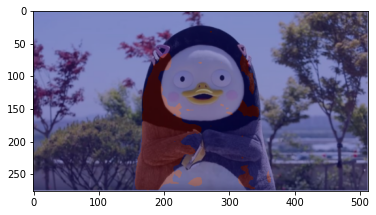

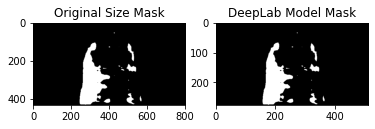

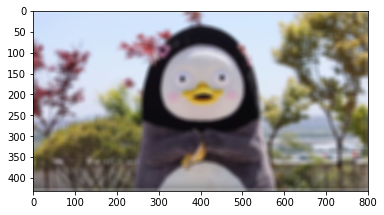

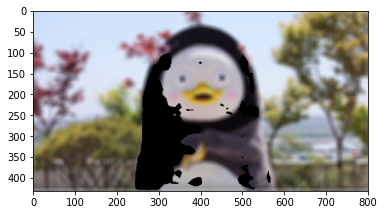

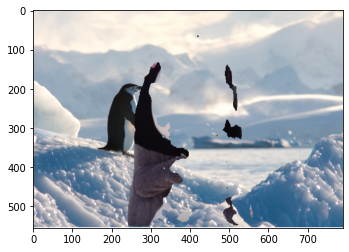

In [98]:
chromakey('image_9.PNG','image_10.PNG')

(478, 635, 3) (386, 513, 3) 15


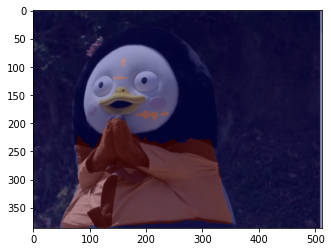

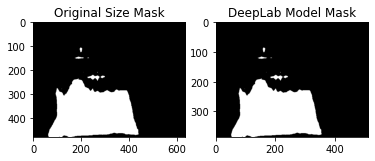

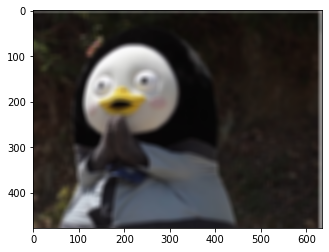

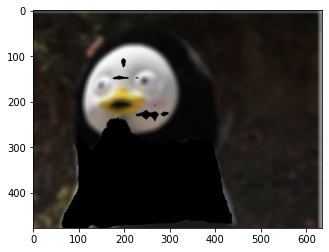

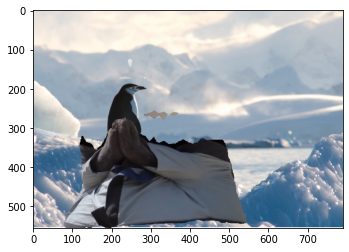

In [99]:
chromakey('image_8.PNG','image_10.PNG')

## 2. 사진에서 문제점 찾기
### 사람 사진에 대한 문제점
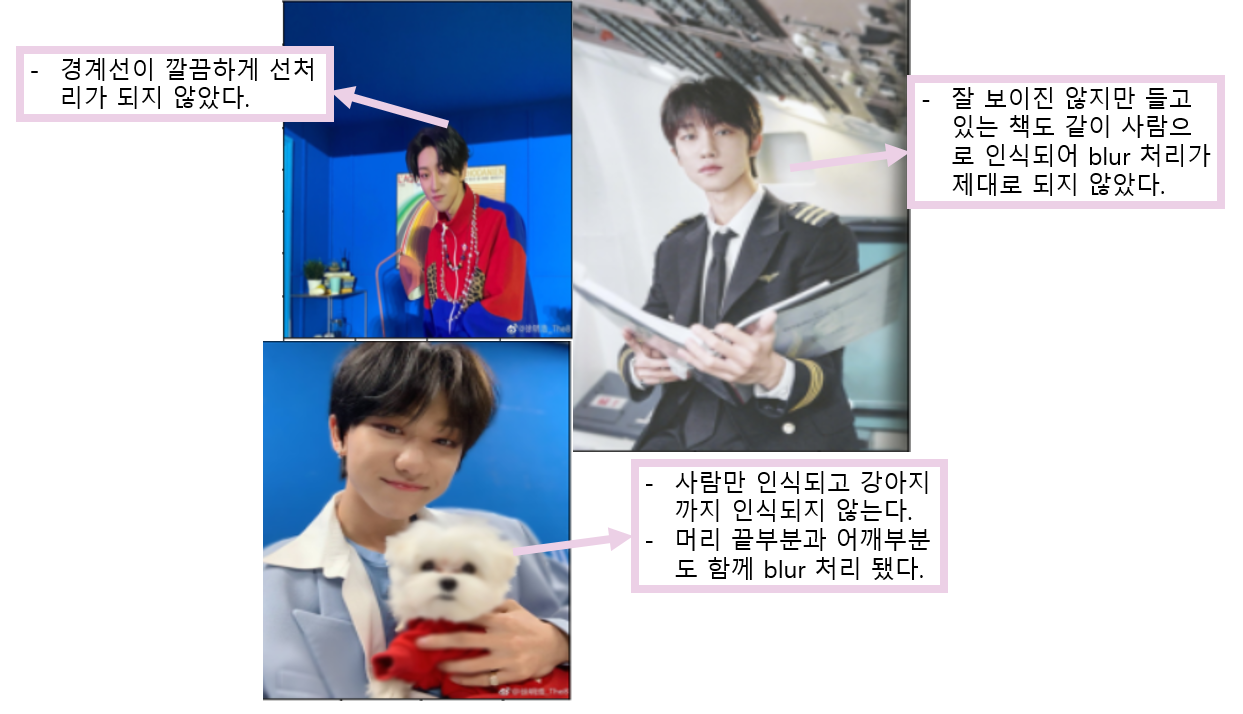
### 고양이 사진에 대한 문제점
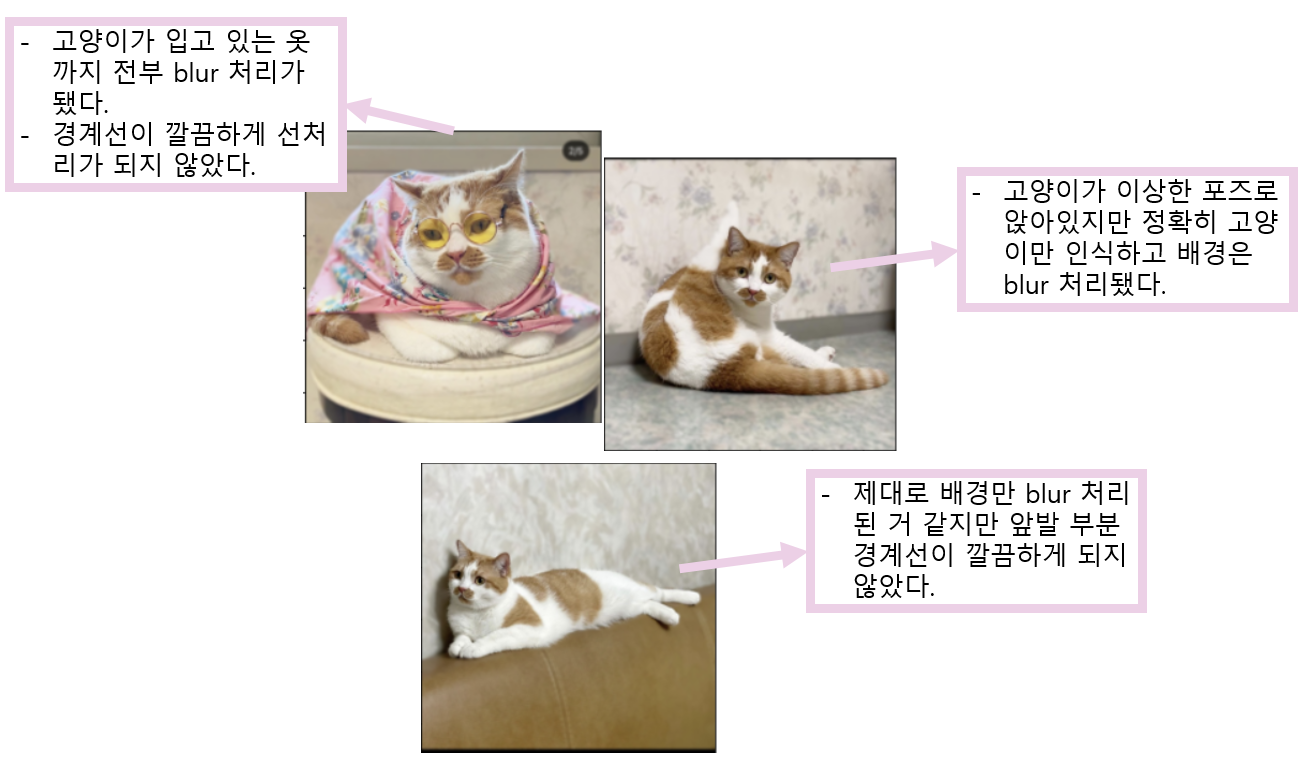
### 인형탈을 쓴 사람에 대한 배경합성 문제점
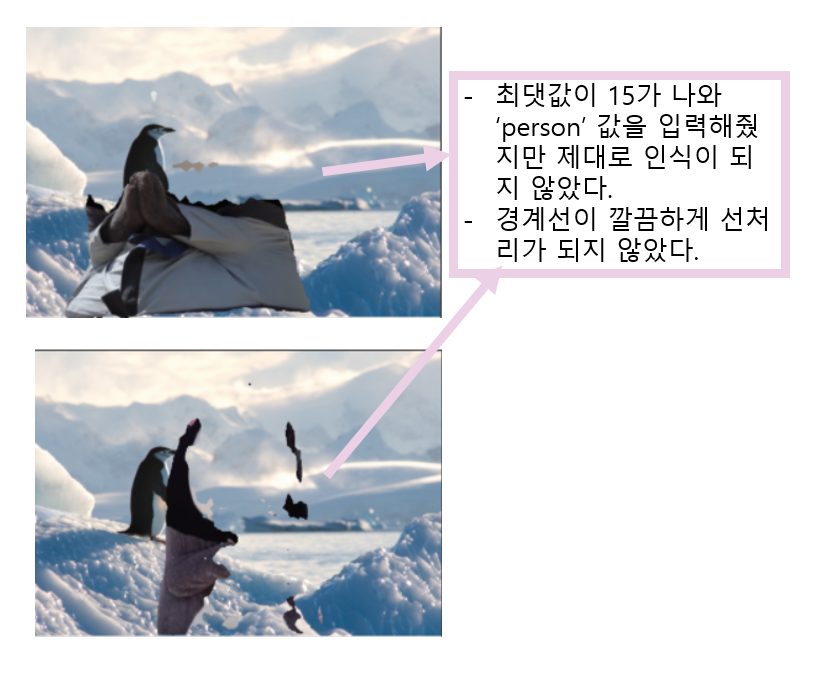

## 3. 해결방법
#### 1) 경계선이 깔끔하게 선처리가 되지 않았다.                                              
깔끔하게 선처리가 되지 않아서 부자연스럽게 합성이 된 것 같다. 해결방안으로 blur 처리를 여러번 한 뒤에 가장 정확하게 피사체를 인식한 것을 뽑아서 합성에 사용한다.

#### 2) 사람과 동물 동시에 인식되지 않았다.                                                 
내가 실력이 부족해서 잘 모르는 걸수도 있지만 사람과 동물을 함께 인식해서 합성하는 방법으로 semmentaion_map을 사람들과 동물들만 동시에 인식할 수 있도록 위치를 지정해준다.     

#### 3) 인형의 탈을 쓴 사람은 동물로 인식해야할 지 사람으로 인식해야 할 지 정확히 구분을 할 수 없다. 이에 대한 해결방법은 더 생각해봐야 할 것 같다.